In [1]:
import os
os.environ["SDSS_LOCAL_SAS_MIRROR"]="/data/jdli/sdss/"
os.environ["RESULTS_VERS"]="dr17"
os.environ["GAIA_TOOLS_DATA"]="/data/jdli/gaia/"

%matplotlib inline
%load_ext autoreload
%autoreload 2
from pylab import *

from astropy.table import Table, join
from astropy.io import fits
from tqdm import tqdm
import numpy as np


In [28]:
from astroquery.gaia import Gaia
import matplotlib.pyplot as plt

In [52]:
Gaia.login()
# jli06
# zwHD5BFFcbT@HZW

INFO: Login to gaia TAP server [astroquery.gaia.core]


User:  jli06
Password:  ········


OK
INFO: Login to gaia data server [astroquery.gaia.core]
OK


In [2]:
cat = Table.read(os.environ["SDSS_LOCAL_SAS_MIRROR"]+"/dr17/ap17_gdr3_tr.fits")
cat.info

names = [name for name in cat.colnames if len(cat[name].shape)<=1]
df_raw = cat[names].to_pandas()


In [3]:
df_raw.columns

Index(['APOGEE_ID', 'TELESCOPE', 'FIELD', 'ALT_ID', 'RA', 'DEC', 'GLON',
       'GLAT', 'J', 'J_ERR', 'H', 'H_ERR', 'K', 'K_ERR', 'AK_TARG',
       'AK_TARG_METHOD', 'AK_WISE', 'SFD_EBV', 'SNR', 'SNREV', 'STARFLAG',
       'STARFLAGS', 'ANDFLAG', 'ANDFLAGS', 'VHELIO_AVG', 'VSCATTER', 'VERR',
       'GAIAEDR3_SOURCE_ID', 'GAIAEDR3_PARALLAX', 'GAIAEDR3_PARALLAX_ERROR',
       'GAIAEDR3_PMRA', 'GAIAEDR3_PMRA_ERROR', 'GAIAEDR3_PMDEC',
       'GAIAEDR3_PMDEC_ERROR', 'GAIAEDR3_PHOT_G_MEAN_MAG',
       'GAIAEDR3_PHOT_BP_MEAN_MAG', 'GAIAEDR3_PHOT_RP_MEAN_MAG',
       'GAIAEDR3_DR2_RADIAL_VELOCITY', 'GAIAEDR3_DR2_RADIAL_VELOCITY_ERROR',
       'GAIAEDR3_R_MED_GEO', 'GAIAEDR3_R_LO_GEO', 'GAIAEDR3_R_HI_GEO',
       'GAIAEDR3_R_MED_PHOTOGEO', 'GAIAEDR3_R_LO_PHOTOGEO',
       'GAIAEDR3_R_HI_PHOTOGEO', 'ASPCAPFLAG', 'ASPCAPFLAGS', 'TEFF',
       'TEFF_ERR', 'LOGG', 'LOGG_ERR', 'M_H', 'M_H_ERR', 'ALPHA_M',
       'ALPHA_M_ERR', 'VSINI', 'source_id', 'visibility_periods_used', 'ruwe'],
      dtype='ob

In [53]:
def chunks(lst, n):
    ""
    "Split an input list into multiple chunks of size =< n"
    ""
    for i in range(0, len(lst), n):
        yield lst[i:i+n]
        
        
dl_threshold = 5000               # DataLink server threshold. It is not possible to download products for more than 5000 sources in one single call.
ids          = cat['GAIAEDR3_SOURCE_ID']
ids_chunks   = list(chunks(ids, dl_threshold))
datalink_all = []


print(f'* Input list contains {len(ids)} source_IDs')
print(f'* This list is split into {len(ids_chunks)} chunks of <= {dl_threshold} elements each')



* Input list contains 88510 source_IDs
* This list is split into 18 chunks of <= 5000 elements each


In [54]:
# retrieval_type = 'XP_SAMPLED'  # Options are: 'EPOCH_PHOTOMETRY', 'MCMC_GSPPHOT', 'MCMC_MSC', 'XP_SAMPLED', 'XP_CONTINUOUS', 'RVS', 'ALL'
retrieval_type = 'XP_CONTINUOUS'
data_structure = 'COMBINED'   # Options are: 'INDIVIDUAL', 'COMBINED', 'RAW'
data_release   = 'Gaia DR3' # Options are: 'Gaia DR3' (default), 'Gaia DR2'
dl_key         = f'{retrieval_type}_{data_structure}.xml'

datalink_all = []

# dl_keys  = [inp for inp in datalink.keys()]
# dl_keys.sort()

ii = 0
for chunk in ids_chunks:
    ii+=1
    print(f'Downloading Chunk #{ii}; N_files = {len(chunk)}')
    datalink  = Gaia.load_data(ids=chunk,
                               data_release = data_release, 
                               retrieval_type=retrieval_type, format='votable',
                               data_structure=data_structure)
    
    datalink_all.append(datalink)

In [84]:
product_list_tb  = [item for sublist in datalink_all for item in sublist[dl_key]]
# product_list_ids = [item.get_field_by_id("source_id") for sublist in datalink_all for item in sublist[dl_key]]
product_list_ids = [sid for sublist in datalink_all for item in sublist[dl_key] for sid in item.array["source_id"].data]



In [190]:
from tqdm import tqdm
N_COEFF = 55


bp_coef = []
rp_coef = []

i = 0
for kk,tab in tqdm(enumerate(product_list_tb)):
    
    bp_coefficients         = np.array([d.data for d in tab.array["bp_coefficients"]]).reshape(-1, N_COEFF)
    bp_coefficients_errors  = np.array([d.data for d in tab.array["bp_coefficient_errors"]]).reshape(-1, N_COEFF)


    rp_coefficients         = np.array([d.data for d in tab.array["rp_coefficients"]]).reshape(-1, N_COEFF)
    rp_coefficients_errors  = np.array([d.data for d in tab.array["rp_coefficient_errors"]]).reshape(-1, N_COEFF)
    
    bp_coef.append(bp_coefficients)
    rp_coef.append(rp_coefficients)
    
bp_coef = np.vstack(tuple([_ for _ in bp_coef]))
rp_coef = np.vstack(tuple([_ for _ in rp_coef]))

print(bp_coef.shape, rp_coef.shape)
print(len(product_list_ids))

18it [00:01, 10.95it/s]


In [203]:
print(bp_coef.shape, rp_coef.shape)
print(len(product_list_ids))

(82655, 55) (82655, 55)
82655


In [201]:
import pandas as pd

df_xpcontinous = pd.DataFrame({'source_id':product_list_ids})

df_xpcontinous = df_xpcontinous.merge(df_raw[['GAIAEDR3_SOURCE_ID', 'J', 'J_ERR', 'H', 'H_ERR', 'K', 'K_ERR', 'TEFF',
       'TEFF_ERR', 'LOGG', 'LOGG_ERR', 'M_H', 'M_H_ERR', 'ALPHA_M',
       'ALPHA_M_ERR']], left_on='source_id', right_on='GAIAEDR3_SOURCE_ID', how='left')
print(df_xpcontinous.shape)

(82655, 16)


In [202]:
df_xpcontinous.head()

,source_id,GAIAEDR3_SOURCE_ID,J,J_ERR,H,H_ERR,K,K_ERR,TEFF,TEFF_ERR,LOGG,LOGG_ERR,M_H,M_H_ERR,ALPHA_M,ALPHA_M_ERR
0,422596679964513792,422596679964513792,10.905,0.023,10.635,0.030,10.483,0.022,6162.030273,41.753815,3.715561,0.025935,-0.221510,0.005673,0.048066,0.009856
1,421077597267551104,421077597267551104,10.664,0.023,10.132,0.030,10.018,0.020,5031.263672,10.145057,3.456132,0.023554,-0.160080,0.006013,0.055704,0.006063
2,429530195985183744,429530195985183744,9.013,0.063,8.029,0.057,7.745,0.020,4073.770020,5.285125,1.281504,0.023255,-0.270330,0.007207,0.055308,0.005488
3,531274466534134272,531274466534134272,9.795,0.023,9.057,0.027,8.872,0.023,4669.081055,7.625217,2.527280,0.022586,-0.124120,0.006263,0.021539,0.005498
4,429484398762416384,429484398762416384,10.702,0.026,10.022,0.032,9.842,0.021,4660.645020,7.267649,2.393895,0.020884,0.046961,0.005847,0.040697,0.004865


In [204]:
mask = (df_xpcontinous['J']>-1) & (df_xpcontinous['J']<20.) &\
        (df_xpcontinous['H']>-0.) & (df_xpcontinous['H']<15.) &\
        (df_xpcontinous['K']>-1.) & (df_xpcontinous['K']<20.) &\
        (df_xpcontinous['M_H']>-5) & (df_xpcontinous['M_H']<1) &\
        (df_xpcontinous['ALPHA_M']>-1) & (df_xpcontinous['ALPHA_M']<1)

print(df_xpcontinous[mask].shape)
data_cont ={'bp_coef':bp_coef[mask], 'rp_coef':rp_coef[mask], 'df':df_xpcontinous[mask]}
np.save(data_dir+"ap17_xpcont_cut.npy", data_cont)

(82062, 16)


In [5]:
data_dir = "/data/jdli/gaia/"

data_cont = np.load(data_dir+"ap17_xpcont_cut.npy", allow_pickle=True).item()
data_cont.keys()

dict_keys(['bp_coef', 'rp_coef', 'df', 'norm_bp_coef', 'norm_rp_codf', 'norm_rp_coef'])

In [6]:
print(np.min(data_cont['bp_coef']), np.min(data_cont['rp_coef']))

-57990.248099869255 -54671.65095261401


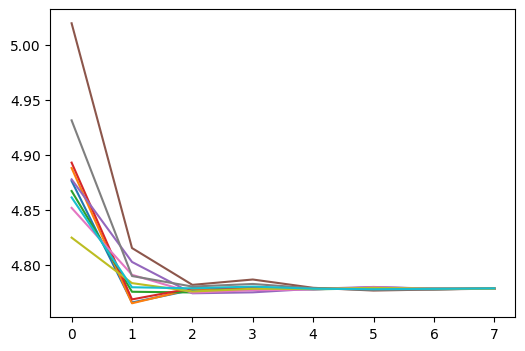

In [10]:
idx_lst = [0, 10, 100, 1000, 10000]
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

# from sklearn import preprocessing
# scaler_bp = preprocessing.RobustScaler()
# scaler_rp = preprocessing.RobustScaler()

# scaler_bp.fit(bp_coef[mask])
# scaler_rp.fit(rp_coef[mask])

for i,idx in enumerate(idx_lst):
    # yy_bp = scaler_bp.transform(bp_coef[mask])[idx]
    # yy_rp = scaler_bp.transform(rp_coef[mask])[idx]
    # print(yy_bp, yy_rp)
    xx = np.arange(8)
    ax.plot(
        xx, np.log10(data_cont['bp_coef'][i,:8]+6*1e4),
    )
    ax.plot(
        xx, np.log10(data_cont['rp_coef'][i,:8]+6*1e4),
    )

In [14]:
data_cont.update(norm_bp_coef=np.log10(data_cont['bp_coef'][:,:8]+6*1e4),
                 norm_rp_coef=np.log10(data_cont['rp_coef'][:,:8]+6*1e4)
                )

np.save(data_dir+"ap17_xpcont_cut.npy", data_cont)



In [15]:
data_cont['norm_bp_coef']

array([[4.87601923, 4.76550835, 4.77693453, ..., 4.77912319, 4.77826308,
        4.77797017],
       [4.86687299, 4.77526313, 4.77463588, ..., 4.7783766 , 4.77762673,
        4.7780592 ],
       [4.87744217, 4.80236807, 4.77387512, ..., 4.77962652, 4.77804534,
        4.77801381],
       ...,
       [4.78416917, 4.78039216, 4.77823241, ..., 4.77818966, 4.77813246,
        4.7781357 ],
       [4.79923624, 4.78248567, 4.77717165, ..., 4.77847133, 4.77812541,
        4.77809679],
       [4.88017224, 4.7887313 , 4.77233828, ..., 4.77882527, 4.77778961,
        4.77810598]])

In [348]:
# import joblib

# joblib.dump(scaler_bp, 'model/scaler_bp.gz')
# joblib.dump(scaler_rp, 'model/scaler_rp.gz')

# # scaler_bp = joblib.load('model/scaler_bp.gz')

['model/scaler_rp.gz']

In [253]:
# data_cont.update(norm_bp_coef=scaler_bp.transform(bp_coef[mask]),
#                  norm_rp_coef=scaler_rp.transform(rp_coef[mask]))

# np.save(data_dir+"ap17_xpcont_cut.npy", data_cont)

In [ ]:
# from tqdm import tqdm

# xp_spec = np.zeros([len(product_list_tb), 343, 3])
# ap_abundance = np.zeros([len(product_list_ids), 2])

# for kk,tab in tqdm(enumerate(product_list_tb)):
    
#     xp_spec[kk,:,0] = tab.array['wavelength'].data
#     flux, eflux = tab.array['flux'].data, tab.array['flux_error'].data
#     flux[flux<=0.], eflux[eflux<=0.] = np.nanmean(flux), np.nanmean(eflux)
    
#     xp_spec[kk,:,1] = np.log10(flux)
#     xp_spec[kk,:,2] = np.log10(eflux)
    
#     match = cat['GAIAEDR3_SOURCE_ID']==product_list_ids[kk]
#     ap_abundance[kk,0] = cat[match]['M_H'].data.data
#     ap_abundance[kk,1] = cat[match]['ALPHA_M'].data.data
    

In [ ]:
data_dir = "/data/jdli/gaia/"

np.save(data_dir+"ap17_xp_raw.npy", {'spec':xp_spec, 'moh':ap_abundance[:,0], 'aom':ap_abundance[:,1], 
                                 'source_id':product_list_ids})


In [ ]:
mask = (ap_abundance[:,0]>-5.) & (ap_abundance[:,0]<1.) & (ap_abundance[:,1]>-5.) & (ap_abundance[:,1]<1.)

np.save(data_dir+"ap17_xp.npy", {'spec':xp_spec[mask], 'moh':ap_abundance[:,0][mask], 
                                 'aom':ap_abundance[:,1][mask], 
                                 'source_id':np.array(product_list_ids)[mask]
                                })
data = np.load(data_dir+"ap17_xp.npy",allow_pickle=True).item()

# preprocess

In [ ]:
data_dir = "/data/jdli/gaia/"

data = np.load(data_dir+"ap17_xp.npy",allow_pickle=True).item()

data.update(norm_spec=minmax(data['spec'][:,:,1]))

data['norm_spec'].shape

np.save(data_dir+"ap17_xp.npy", data)

In [25]:
data = np.load(data_dir+"ap17_xp.npy",allow_pickle=True).item()
print(data.keys())


dict_keys(['spec', 'moh', 'aom', 'source_id', 'norm_spec'])


In [33]:
Js, Hs, Kss = [], [], []

for sid in data['source_id']:
    
    match = cat['GAIAEDR3_SOURCE_ID']==sid
    Js.append(df_raw[match]['J'].values)
    Hs.append(df_raw[match]['H'].values)
    Kss.append(df_raw[match]['K'].values)

In [51]:
Js  = np.array(Js).reshape(-1)
Hs  = np.array(Hs).reshape(-1)
Kss = np.array(Kss).reshape(-1)

mask = (Js>-1) & (Js<20.) & (Hs>-0.) & (Hs<15.) & (Kss>-1.) & (Kss<20.)
      

data_cut ={'spec':data['spec'][mask],
           'moh':data['moh'][mask], 'aom':data['aom'][mask], 
           'source_id':data['source_id'][mask],
           'norm_spec':data['norm_spec'][mask],
           'J':data['J'][mask], 'K':data['K'][mask], 'H':data['H'][mask]
           
          }

np.save(data_dir+"ap17_xpcut.npy", data_cut)

In [ ]:
idx = 0
lnflux = data['norm_spec'][idx]

photo = np.vstack([data['J'][idx], 
                   data['H'][idx], 
                   data['K'][idx]]).reshape(-1)

np.hstack([lnflux, photo]).reshape(1,-1).astype(np.float32).shape

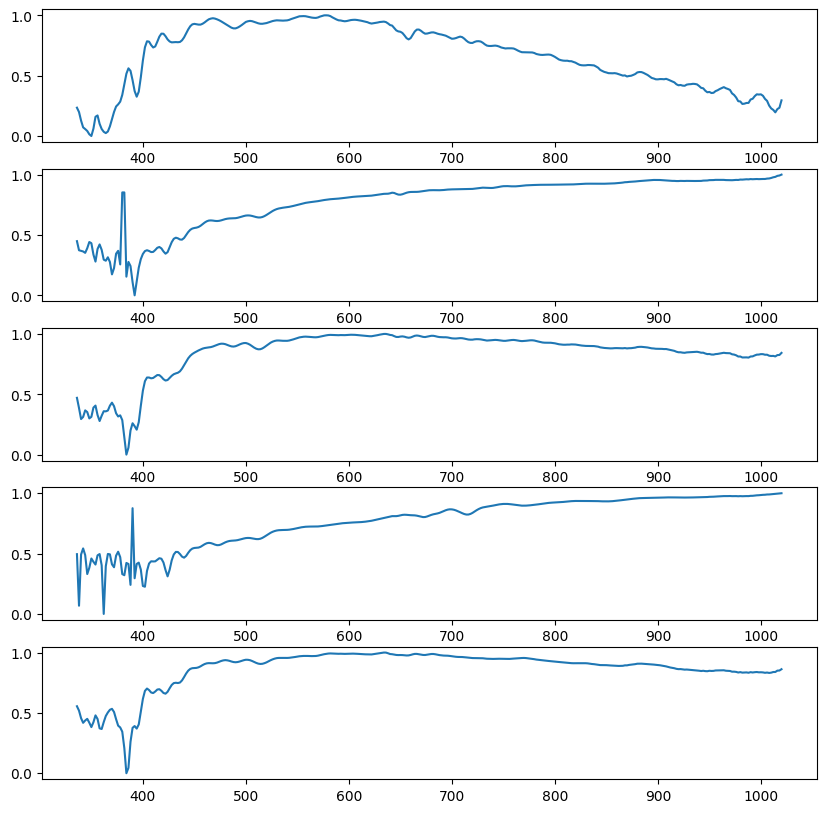

In [44]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
def minmax(X):
    X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
    return X_std 


idx_lst = [0, 10, 100, 1000, 10000]
fig, axs = plt.subplots(len(idx_lst), 1, figsize=(10, 2*len(idx_lst)))

for i,idx in enumerate(idx_lst):
    norm_spec = minmax(data['spec'][idx,:,1])
    axs[i].plot(
        data['spec'][idx,:,0], 
        norm_spec.reshape(-1),
    )
    # axs[i].set_xticks([]);


# Simple XGboost regression

In [167]:
import xgboost as xgb
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

print(len(cat))
X = data['norm_spec']
Y = np.c_[data['moh'], data['aom']]

# mask = np.isnan(Y)[:,0] & np.isnan(Y)[:,1]
mask = (Y[:,0]>-1.) & (Y[:,0]<1.) 
# & (Y[:,1]>-5.) & (Y[:,1]<1.)
X, Y = X[mask], Y[mask]
print(X.shape, Y.shape)

np.save(data_dir+"ap17_xp_post.npy", X, Y)


X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.05, random_state=42
)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

88510
(77724, 343) (77724, 2)
(73837, 343) (3887, 343) (73837, 2) (3887, 2)


In [ ]:
?xgb.XGBRegressor

In [192]:
reg = xgb.XGBRegressor(
    eval_metric=mean_squared_error, learning_rate=1, n_jobs=32,
    reg_alpha=0.5, gamma=0.5,
)

reg.fit(X_train, y_train, 
        # eval_set=[(X_test, y_test)]
       )

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=<function mean_squared_error at 0x7f0699c5bc10>,
             gamma=0.5, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='', learning_rate=1,
             max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=6,
             max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=32,
             num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0.5, reg_lambda=1, ...)

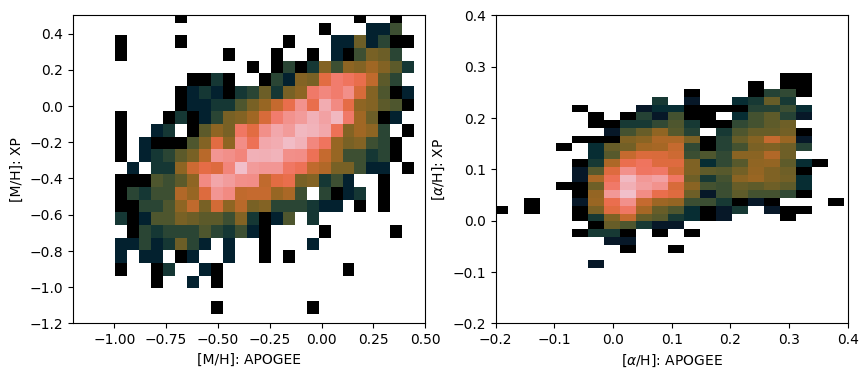

In [227]:
y_pred = reg.predict(X_test)

fig, axs = plt.subplots(1,2, figsize=(10,4))
ax1, ax2 = axs.ravel()

# ax1.scatter(y_train[:,0], y_pred[:,0], s=1)
# ax1.scatter(y_test[:,0], y_pred[:,0], s=1)
ax1.hist2d(y_test[:,0], y_pred[:,0], norm=LogNorm(), bins=25, cmap=cmap)

ax1.set_xlim([-1.2, 0.5]);
ax1.set_ylim([-1.2, 0.5]);
ax1.set_xlabel("[M/H]: APOGEE");
ax1.set_ylabel("[M/H]: XP");


# ax2.scatter(y_test[:,1], y_pred[:,1], s=1)
ax2.hist2d(y_test[:,1], y_pred[:,1], norm=LogNorm(), bins=25, cmap=cmap)

ax2.set_xlim([-0.2, 0.4]);
ax2.set_ylim([-0.2, 0.4]);
ax2.set_ylabel(r"[$\alpha$/H]: XP");
ax2.set_xlabel(r"[$\alpha$/H]: APOGEE");


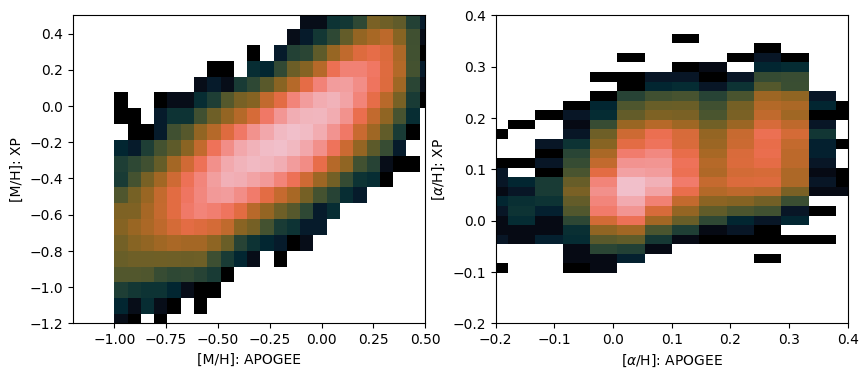

In [228]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
cmap = plt.get_cmap('cmr.dusk')  

y_pred = reg.predict(X_train)

fig, axs = plt.subplots(1,2, figsize=(10,4))
ax1, ax2 = axs.ravel()

ax1.hist2d(y_train[:,0], y_pred[:,0], norm=LogNorm(), bins=25, cmap=cmap)
# ax1.scatter(y_test[:,0], y_pred[:,0], s=1)
ax1.set_xlim([-1.2, 0.5]);
ax1.set_ylim([-1.2, 0.5]);
ax1.set_xlabel("[M/H]: APOGEE");
ax1.set_ylabel("[M/H]: XP");


ax2.hist2d(y_train[:,1], y_pred[:,1], norm=LogNorm(), bins=25, cmap=cmap)
ax2.set_xlim([-0.2, 0.4]);
ax2.set_ylim([-0.2, 0.4]);
ax2.set_ylabel(r"[$\alpha$/H]: XP");
ax2.set_xlabel(r"[$\alpha$/H]: APOGEE");


In [ ]:
## plt.hist(y_test[:,0] - y_pred[:,0], bins=20, alpha=0.5);


In [191]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())


rmse(y_pred[:,0], y_test[:,0])

0.23047295272763546

# Trans. prediction

In [2]:
import sys
sys.path.append("/home/jdli/TransSpectra/")

In [3]:
%load_ext autoreload
%autoreload 2

In [254]:
import torch
from torch.utils.data import DataLoader
# from transformer import TransformerReg, TransAm
from model import Spec2label, smape_loss
from data import GaiaXPlabel_cont
from matplotlib.colors import LogNorm
import cmasher as cmr
import copy
from pylab import *

In [255]:
data_dir = "/data/jdli/gaia/"
tr_file = "ap17_xpcont_cut.npy"

device = torch.device('cuda:1')
TOTAL_NUM = 6000
BATCH_SIZE = 1024

gdata  = GaiaXPlabel_cont(data_dir+tr_file, total_num=TOTAL_NUM,
part_train=False, device=device)

val_size = int(0.1*len(gdata))
A_size = int(0.5*(len(gdata)-val_size))
B_size = len(gdata) - A_size - val_size

A_dataset, B_dataset, val_dataset = torch.utils.data.random_split(gdata, [A_size, B_size, val_size], generator=torch.Generator().manual_seed(42))
print(len(A_dataset), len(B_dataset), len(val_dataset))

A_loader = DataLoader(A_dataset, batch_size=BATCH_SIZE, )
B_loader = DataLoader(B_dataset, batch_size=BATCH_SIZE, )
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

36928 36928 8206


In [256]:
import copy

# modelA = Spec2label(
#         n_encoder_inputs=343,
#         n_outputs=2,
#         lr=1e-5,
#         dropout=0.1,
#     ).to(device)
modelA = Spec2label(
        n_encoder_inputs=55*2+3,
        n_outputs=2,
        lr=1e-5,
        dropout=0.2,
        channels=128,
        n_heads=8,
        n_layers=8,
    ).to(device)

modelB = copy.deepcopy(modelA)

# modelA = TransAm(feature_size=64, enc_len=343, tgt_len=2, num_layers=2, dropout=0.2).to(device)
# modelB = copy.deepcopy(modelA)

In [371]:
!ls -al /data/jdli/gaia/model/GXPcont_abundance/


total 200700
drwxrwxr-x. 3 jdli jdli     4096 Nov 12 05:51 .
drwxrwxr-x. 4 jdli jdli     4096 Nov 11 11:42 ..
drwxrwxr-x. 2 jdli jdli     4096 Nov 12 23:17 1111
-rw-rw-r--. 1 jdli jdli  7521649 Nov 11 13:59 enc_GXPcont_221110_NGlll_A_ep0.pt
-rw-rw-r--. 1 jdli jdli  7521649 Nov 11 17:13 enc_GXPcont_221110_NGlll_A_ep100.pt
-rw-rw-r--. 1 jdli jdli  7521649 Nov 11 20:26 enc_GXPcont_221110_NGlll_A_ep200.pt
-rw-rw-r--. 1 jdli jdli  7521649 Nov 11 23:39 enc_GXPcont_221110_NGlll_A_ep300.pt
-rw-rw-r--. 1 jdli jdli  7521649 Nov 12 02:50 enc_GXPcont_221110_NGlll_A_ep400.pt
-rw-rw-r--. 1 jdli jdli  7521649 Nov 12 05:50 enc_GXPcont_221110_NGlll_A_ep500.pt
-rw-rw-r--. 1 jdli jdli  7521649 Nov 11 11:55 enc_GXPcont_221110_NGlllAep500.pt
-rw-rw-r--. 1 jdli jdli  7521649 Nov 11 13:57 enc_GXPcont_221110_NGlll_A_ep63.pt
-rw-rw-r--. 1 jdli jdli  7521649 Nov 11 13:57 enc_GXPcont_221110_NGlll_B_ep0.pt
-rw-rw-r--. 1 jdli jdli  7521649 Nov 11 11:53 enc_GXPcont_221110_NGlllBep0.pt
-rw-rw-r--. 1 jdli jdli  75216

In [367]:
model_name_A = '/model/GXPcont_abundance/1111/enc_GXPcont_221110_NGlll_A_ep1001.pt'
model_name_B = '/model/GXPcont_abundance/enc_GXPcont_221110_NGlll_B_ep300.pt'

modelA.load_state_dict(torch.load(data_dir+model_name_A))
modelB.load_state_dict(torch.load(data_dir+model_name_B))


<All keys matched successfully>

In [ ]:
# def predict(dataset, model, y_grid, N=1000):
#     out_lst, y_lst = np.array([]), np.array([])
#     id_lst = []
    
#     y_grid_arr = y_grid.cpu().numpy().reshape(N,2)

#     with torch.no_grad():
#         for i,data in tqdm(enumerate(dataset)):
            
#             if i <10:
#                 output = np.array([model(data['x'].reshape(1,-1,1), 
#                                          y_grid[i].reshape(1,2,1)).cpu().numpy() for i in range(N)])
#                 output = output.reshape(N, 2)

#                 loss = mse(output, y_grid_arr, ax=1)
#                 ind = np.argmin(loss)

#                 out_lst = np.append(out_lst, y_grid_arr[ind])
#                 y_lst   = np.append(y_lst, data['y'].cpu().numpy())
#             # id_batch =  list(np.int64(data['id']))
#             # del output, data
            
#             # for idl in id_batch:
#             #     id_lst.append(idl)
#     out_lst, y_lst = np.array(out_lst).reshape(-1,2), np.array(y_lst).reshape(-1,2)
#     return out_lst, y_lst, id_lst

# out_lst_B1, y_lst_B1, idB1 = predict(B_dataset, modelA, y_grid)


In [ ]:
# criterion = torch.nn.GaussianNLLLoss(full=True, reduction='sum')

# x = A_dataset[0]['x']
# y = A_dataset[0]['y']

# with torch.no_grad():
    
#     output = modelB(x.reshape(1, 1, -1))
#     print(criterion(output, y, 0.1*y.abs()))
    
#     print(criterion(output[:,0], y[:,0], 0.1*y.abs()[:,0]))
#     print(criterion(output[:,1], y[:,1], 0.1*y.abs()[:,1]))

In [368]:
from tqdm import tqdm


def predict(data_loader, model):
    
    out_lst, y_lst = np.array([]), np.array([])
    id_lst = []

    with torch.no_grad():
        for data in tqdm(data_loader):
            # output = model(data['x'], data['y'])
            output = model(data['x'])
            out_lst = np.append(out_lst, output.cpu().numpy())
            y_lst   = np.append(y_lst, data['y'].cpu().numpy())
            
            id_batch =  list(np.int64(data['id']))
            
            del output, data
            
            for idl in id_batch:
                id_lst.append(idl)

    out_lst, y_lst = np.array(out_lst).reshape(-1,2), np.array(y_lst).reshape(-1,2)
    return out_lst, y_lst, id_lst


out_lst_B1, y_lst_B1, idB1 = predict(B_loader, modelA)
out_lst_A1, y_lst_A1, idA1 = predict(A_loader, modelB)


100%|██████████████████████████████████████████████████████████████████████| 37/37 [01:25<00:00,  2.30s/it]


In [320]:
# # modelA.load_state_dict(torch.load(data_dir+model_name_A))

out_lst_B2, y_lst_B2, idB2 = predict(B_loader, modelB)
out_lst_A2, y_lst_A2, idA2 = predict(A_loader, modelA)

print(np.count_nonzero(~idA1==idA2), np.count_nonzero(~idB1==idB2))


100%|████████████████████████████████████████████████████████████████████████| 37/37 [01:29<00:00,  2.41s/it]

36928 36928


In [345]:
df_result = pd.DataFrame(
    {'source_id':np.append([np.int64(i) for i in idA1], [np.int64(i) for i in idB1]),
     'moh_model_cross':np.append(out_lst_A1[:,0],out_lst_B1[:,0]),
     'aom_model_cross':np.append(out_lst_A1[:,1],out_lst_B1[:,1]),
     'moh_model_self':np.append(out_lst_A2[:,0],out_lst_B2[:,0]),
     'aom_model_self':np.append(out_lst_A2[:,1],out_lst_B2[:,1]),
     'set_id':np.append(['A' for i in range(len(out_lst_A1))], 
                        ['B' for i in range(len(out_lst_B1))]),
    }
)

df_result["source_id"] = pd.to_numeric(df_result["source_id"])
# df_result["source_id"] = df_result["source_id"].apply(str)
df_result.to_csv(data_dir+"/model/GXPcont_abundance/xp_abundance.csv", index=False)



In [347]:
# df_raw["source_id"] = df_raw["source_id"].apply(str)
df_raw["source_id"] = pd.to_numeric(df_raw["source_id"])

df_com = pd.merge(df_result, df_raw, left_on='source_id', right_on='source_id')
print(df_com.shape)

df_com.to_csv(data_dir+"/model/GXPcont_abundance/xp_valid.csv", index=False)

(73856, 64)


In [352]:
df_com = df_com.assign(tmass_id = [i.decode('utf-8').strip() for i in df_com['APOGEE_ID'].values])


df_com.to_csv(data_dir+"/model/GXPcont_abundance/xp_valid.csv", index=False)

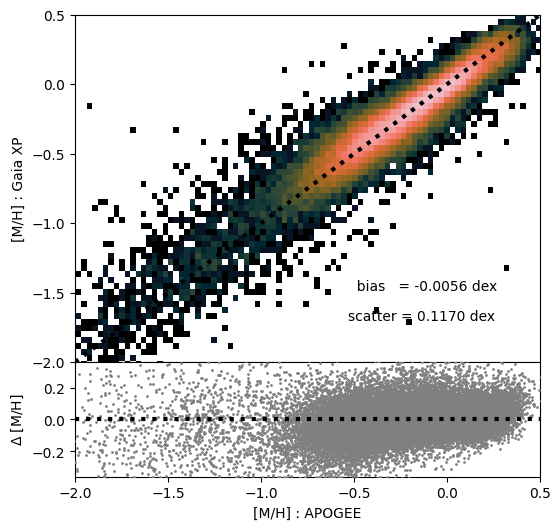

In [369]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
cmap = plt.get_cmap('cmr.dusk')   # MPL


def draw_compare(out_lst, y_lst, xmin=-2, xmax=0.5):
    xx = np.linspace(xmin, xmax)
    
    norm_res = y_lst-out_lst
    
    fig, ax = plt.subplots(1,1, figsize=(6,6),  sharex=True)
    ax.plot(xx, xx, ls=':', lw=3, c='k', zorder=5)
    
    # ax.scatter(y_lst, out_lst, s=1,
    #            marker='.', c='royalblue', alpha=0.5, zorder=4)
    ax.hist2d(y_lst, out_lst, bins=100, cmap=cmap, zorder=4, norm=LogNorm())
    ax.set_xlim([xmin, xmax]);
    ax.set_ylim([xmin, xmax]);
    ax.set_ylabel(r"Trans.");
    ax.annotate("scatter = %.4f dex"%(np.nanstd(norm_res)), 
                (0.58, 0.35), xycoords="figure fraction",zorder=3)
    ax.annotate("  bias   = %.4f dex"%(np.nanmean(norm_res)), 
                (0.58, 0.40), xycoords="figure fraction",zorder=3)
    
    divider = make_axes_locatable(ax)
    ax2 = divider.append_axes("bottom", size="33%", pad=0)

    ax.figure.add_axes(ax2)
    ax2.scatter(y_lst, norm_res, color="grey", s=1, zorder=5)
    ax2.axhline(y=0, c='k', zorder=6, lw=3, ls=":")
    ax2.set_xlabel(r"APOGEE");
    ax2.set_ylim([-0.36, 0.36]);
    ax2.set_xlim([xmin, xmax]);
    
    ax.set_xticks([]);

    return fig, ax, ax2

fig, ax, ax2 = draw_compare(out_lst_B1[:,0], y_lst_B1[:,0],)
ax2.set_xlabel(r"[M/H] : APOGEE");
ax.set_ylabel(r"[M/H] : Gaia XP");
ax2.set_ylabel(r'$\Delta$ [M/H]');

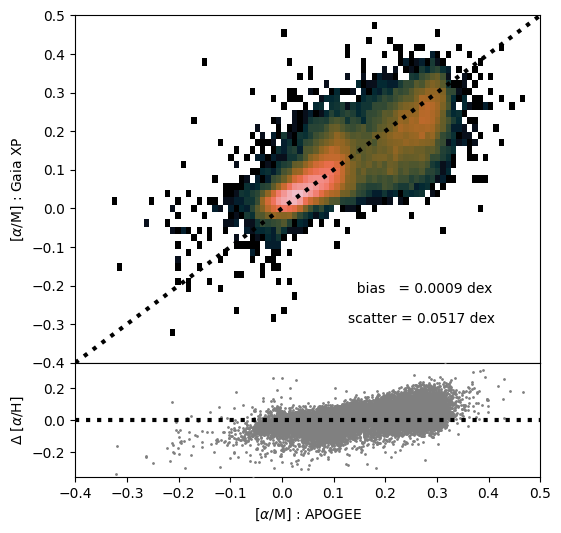

In [370]:

fig, ax, ax2 = draw_compare(out_lst_B1[:,1], y_lst_B1[:,1],xmin=-0.4, xmax=0.5)
ax2.set_xlabel(r"[$\alpha$/M] : APOGEE");
ax.set_ylabel(r"[$\alpha$/M] : Gaia XP");
ax2.set_ylabel(r'$\Delta$ [$\alpha$/H]');


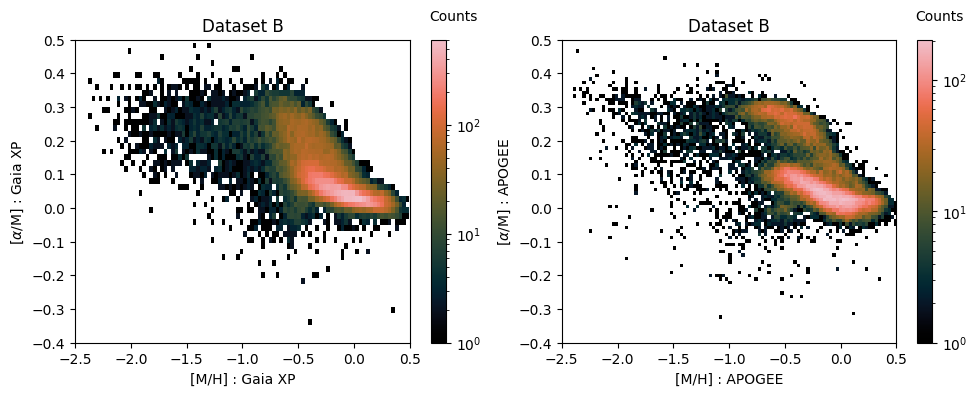

In [360]:
fig, axs = plt.subplots(1,2, figsize=(10,4))
ax1, ax2 = axs.ravel()

_, _, _, img1 = ax1.hist2d(out_lst_B1[:,0], out_lst_B1[:,1], bins=100, norm=LogNorm(), 
                           cmap=cmap)
_, _, _, img2 = ax2.hist2d(y_lst_B1[:,0], y_lst_B1[:,1], bins=100, norm=LogNorm(), 
                           cmap=cmap)

clb1 = fig.colorbar(img1, ax=ax1,);
clb1.set_label('Counts', labelpad=-20, y=1.1, rotation=0)
               
clb2 = fig.colorbar(img2, ax=ax2, );
clb2.set_label('Counts', labelpad=-20, y=1.1, rotation=0)

ax1.set_xlabel("[M/H] : Gaia XP");
ax1.set_ylabel(r"[$\alpha$/M] : Gaia XP");

ax2.set_xlabel("[M/H] : APOGEE");
ax2.set_ylabel(r"[$\alpha$/M] : APOGEE");
plt.tight_layout()

for ax in axs.ravel():
    ax.set_title("Dataset B");
    ax.set_xlim([-2.5, 0.5]);
    ax.set_ylim([-0.4, 0.5])
    
plt.tight_layout()